In [1]:
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2023-12-04 17:47:18.740079: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 17:47:18.749526: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 17:47:18.932611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 17:47:18.932721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 17:47:18.962401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [14]:
df = pd.read_csv("../../data/data_pred_ci3.csv")
df["CI3"] = df["CI3"].apply(lambda x: 2 if x == 4 else x)

In [15]:
y = df["CI3"].values
X = df.drop(columns=["CI3", "Unnamed: 0"]).values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(8, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [39]:
import random
random.seed(42)

Epoch 1/50
2/2 [==============================] - 1s 282ms/step - loss: 1.1123 - accuracy: 0.3182 - val_loss: 1.3474 - val_accuracy: 0.3043
Epoch 2/50
2/2 [==============================] - 0s 48ms/step - loss: 1.0500 - accuracy: 0.3864 - val_loss: 1.3150 - val_accuracy: 0.3043
Epoch 3/50
2/2 [==============================] - 0s 32ms/step - loss: 1.0074 - accuracy: 0.4318 - val_loss: 1.2875 - val_accuracy: 0.3043
Epoch 4/50
2/2 [==============================] - 0s 34ms/step - loss: 0.9701 - accuracy: 0.4318 - val_loss: 1.2648 - val_accuracy: 0.3478
Epoch 5/50
2/2 [==============================] - 0s 34ms/step - loss: 0.9417 - accuracy: 0.4545 - val_loss: 1.2448 - val_accuracy: 0.3913
Epoch 6/50
2/2 [==============================] - 0s 33ms/step - loss: 0.9154 - accuracy: 0.4545 - val_loss: 1.2289 - val_accuracy: 0.3913
Epoch 7/50
2/2 [==============================] - 0s 29ms/step - loss: 0.8962 - accuracy: 0.4773 - val_loss: 1.2161 - val_accuracy: 0.3913
Epoch 8/50
2/2 [==========

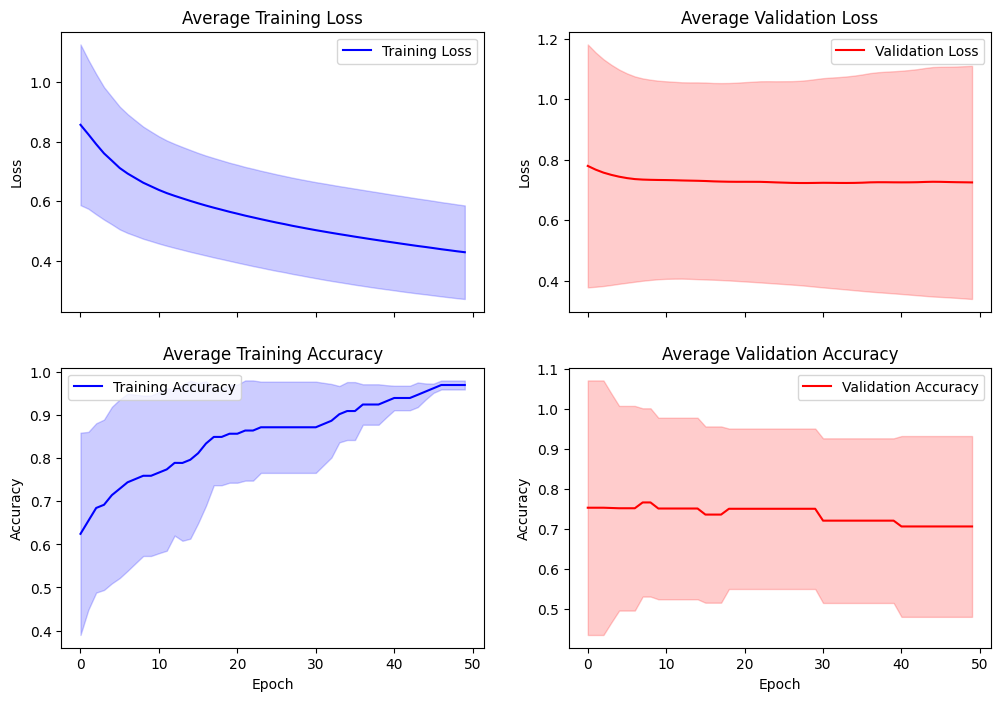

In [52]:
model = create_model()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y, shuffle=True)

# Set the number of folds
k_folds = 3

# Create KFold cross-validation object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# K-fold cross-validation on the training set
cv_accuracies = []
all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model on the validation fold
    val_predictions = model.predict(X_val_fold)
    val_class_predictions = np.argmax(val_predictions, axis=1)
    val_accuracy = accuracy_score(y_val_fold, np.round(val_class_predictions))
    cv_accuracies.append(val_accuracy)
    
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

# Print the cross-validation results
print("Cross-validation accuracies:", cv_accuracies)
print("Mean accuracy: {:.2f}%".format(np.mean(cv_accuracies) * 100))

# Train the final model on the entire training set
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

